In [127]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

CRITICAL_TEMP = 'critical_temp'

In [154]:
# setup matplotlib

fontsize = "13";
params = {
    'figure.autolayout':True,
    'legend.fontsize': fontsize,
    'figure.figsize': (12, 8),
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize
}
plt.rcParams.update(params)

In [147]:
def print_metrics(y, y_hat):
    rmse = mean_squared_error(y, y_hat, squared=False)
    r2 = r2_score(y, y_hat)
    print(f'RMSE: {rmse:.4f}\nR^2: {r2:.4f}')
    
def run_linear_regression(X, y, should_print_metrics=True):
    linreg = LinearRegression().fit(X, y)
    y_hat = linreg.predict(X)

    if should_print_metrics:
        print_metrics(y, y_hat)
    
    return y_hat

In [126]:
df = pd.read_csv('train.csv')

all_X = df.loc[:, :'wtd_std_Valence']
all_y = df[CRITICAL_TEMP]

# test size 0.33 to match paper
X, X_test, y, y_test = train_test_split(all_X, all_y, test_size=0.33, random_state=42)

X

,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence
12733,2,53.385500,53.385500,32.209060,32.209060,0.327830,0.327830,85.149000,42.574500,42.574500,...,4.500000,4.500000,4.242641,4.242641,0.636514,0.636514,3,1.500000,1.500000,1.500000
20046,3,69.869857,55.405068,46.092010,32.931485,0.792946,0.885528,126.894770,28.721017,52.403916,...,3.000000,3.250000,2.884499,3.130169,1.060857,0.925129,2,1.500000,0.816497,0.829156
8658,5,74.231650,52.487708,60.515221,35.908285,1.453747,1.311429,121.327600,21.607086,39.445875,...,2.200000,2.079618,2.168944,2.065618,1.594167,1.239131,1,1.036624,0.400000,0.270701
8345,5,100.548964,87.174774,75.449113,71.619096,1.399121,1.318253,180.967169,36.950657,62.132743,...,2.800000,2.271429,2.605171,2.204147,1.531778,1.512101,3,0.557143,1.166190,0.674461
4638,7,115.323400,87.694604,83.550312,68.201146,1.703770,1.581531,192.981000,31.836924,76.422671,...,3.285714,2.580000,2.944713,2.390576,1.836012,1.708707,4,0.740000,1.577909,1.176265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,2,25.643269,25.348850,25.608325,25.315724,0.691785,0.678668,2.676539,4.303250,1.338269,...,2.500000,2.390000,2.449490,2.342640,0.673012,0.692928,1,0.050000,0.500000,0.487750
11964,4,144.041845,128.014563,135.218871,120.611379,1.325694,1.318069,102.177620,32.495603,49.630753,...,5.750000,5.833333,5.732657,5.820421,1.383370,1.224634,1,2.166667,0.433013,0.372678
5390,5,95.509280,56.977188,73.307186,36.853454,1.419515,1.484104,157.054600,14.484329,55.077433,...,2.200000,2.078431,2.168944,2.064624,1.594167,1.287474,1,0.996078,0.400000,0.268849
860,4,92.505350,60.961000,68.030395,36.899835,1.172035,0.995372,134.360600,36.735514,55.465617,...,2.750000,2.307143,2.632148,2.259535,1.342113,1.096043,2,1.057143,0.829156,0.505632


In [124]:
aggregations = "wtd gmean entropy range std".split()
def is_aggregated(cat):
    return any(agg in cat for agg in aggregations)

raw_categories = [cat for cat in list(X) if not is_aggregated(cat)]

X_and_y = X.copy()
X_and_y.loc[:, CRITICAL_TEMP] = y

critical_temp_correlation = X_and_y.corr()[CRITICAL_TEMP].copy()
critical_temp_correlation = critical_temp_correlation.drop(CRITICAL_TEMP)

# critical_temp_correlation.abs().sort_values(ascending=False)[-20:]

critical_temp_correlation.abs().mean()

0.3861139674822097

In [151]:
run_linear_regression(X, y);

RMSE: 17.5114
R^2: 0.7398


Optimal number of features : 79


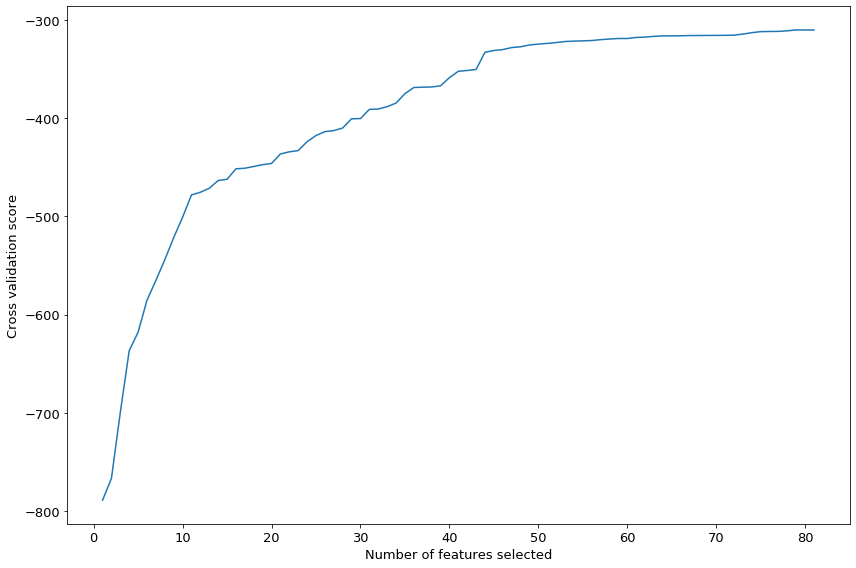

In [162]:
linreg = LinearRegression().fit(X, y)
rfecv = RFECV(estimator=linreg, scoring="neg_mean_squared_error")
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [161]:
mask = rfecv.support_
dropped = []
for i, isSelected in enumerate(mask):
    if not isSelected:
        dropped.append(list(X)[i])

print("\n".join(dropped))

wtd_mean_Density
wtd_range_Density


In [163]:
X_reduced = X.drop(dropped, axis=1)
run_linear_regression(X_reduced, y);

# TODO why is this lower than with all features?

RMSE: 17.5117
R^2: 0.7398


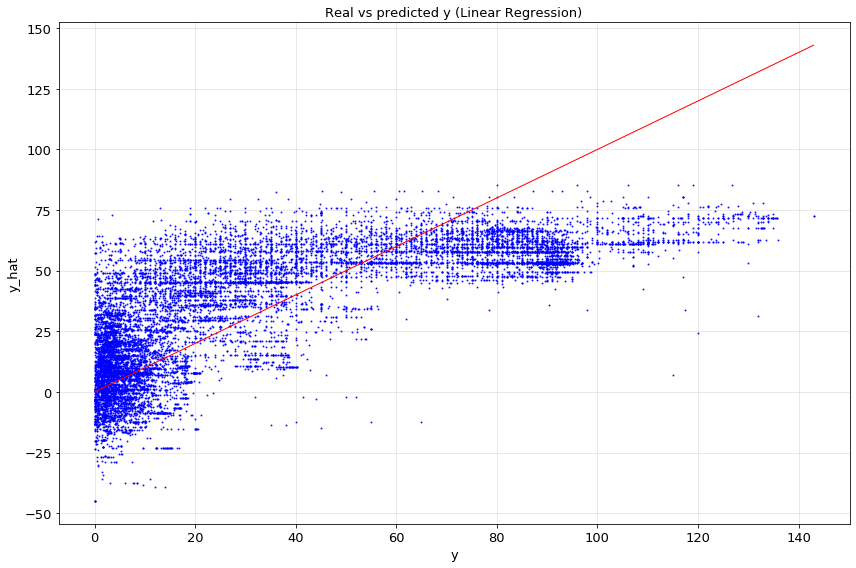

In [155]:
fig, ax = plt.subplots()

# Draw a scatter plot of the predicted vs real y
ax.scatter(y, y_hat, color='blue', alpha=.8, s=1, marker='o')
ax.set_xlabel('y')
ax.set_ylabel('y_hat')
ax.grid(color='lightgray', linestyle='-', linewidth=.5)
ax.set_axisbelow(True)
ax.set_title("Real vs predicted y (Linear Regression)")

# Draw x = y for reference
max_val = max(y.max(), y_hat.max())
ax.plot([0, max_val], [0, max_val] ,color='red', linewidth='1')